<a href="https://colab.research.google.com/github/profsuccodifrutta/Variational_Autoencoder_for_Anomaly_Detection/blob/main/fourth_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Crea una cartella locale su Colab per i dati (veloce)
!mkdir -p /content/dataset_local

# Scompatta il file.
path_zip = "/content/drive/MyDrive/brainmri.zip"

!unzip -o -q "{path_zip}" -d /content/dataset_local

print("Scompattamento completato!")

Scompattamento completato!


In [ ]:
# cosa c'è dentro cartella locale
#!ls -R /content/dataset_local

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [ ]:
!pip freeze | grep torch >> requirments.txt

In [6]:
# p
#import os
#os.makedirs("/content/drive/MyDrive/VAE_Brain_Project", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import glob
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, random_split

# 1. Puntiamo ai dati sani
file_sani = glob.glob("/content/dataset_local/**/Training/notumor/*.jpg", recursive=True)

print(f"--- ANALISI DATASET ---")
print(f"Totale immagini sane trovate: {len(file_sani)}")

# 2. Classe Dataset
class BrainDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

# 3. Creazione Split (70% Train, 20% Val, 10% Test)
if len(file_sani) > 0:
    full_healthy_ds = BrainDataset(file_sani)

    train_size = int(0.7 * len(full_healthy_ds))
    val_size = int(0.2 * len(full_healthy_ds))
    test_size = len(full_healthy_ds) - train_size - val_size

    train_subset, val_subset, test_healthy_subset = random_split(
        full_healthy_ds, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"\n--- DISTRIBUZIONE SPLIT (Solo Sani) ---")
    print(f"✅ Training:   {len(train_subset)} immagini (usate per imparare la normalità)")
    print(f"⚠️ Validation: {len(val_subset)} immagini (usate per monitorare l'allenamento)")
    print(f"🛡️ Test Sani:  {len(test_healthy_subset)} immagini (usate per valutare i falsi allarmi)")

    # 4. Recuperiamo le anomalie per il Test finale
    file_anomalie = glob.glob("/content/dataset_local/**/Testing/*/*.jpg", recursive=True)
    # Filtriamo via i sani dalla cartella Testing per avere solo anomalie vere
    file_anomalie = [f for f in file_anomalie if "notumor" not in f]

    print(f"\n--- DATI PER TEST ANOMALIE ---")
    print(f"🚨 Anomalie:  {len(file_anomalie)} immagini (glioma, meningioma, etc.)")
else:
    print("❌ ERRORE: Non ho trovato le immagini. Controlla se la cartella 'Training/notumor' esiste.")

--- ANALISI DATASET ---
Totale immagini sane trovate: 1595

--- DISTRIBUZIONE SPLIT (Solo Sani) ---
✅ Training:   1116 immagini (usate per imparare la normalità)
⚠️ Validation: 319 immagini (usate per monitorare l'allenamento)
🛡️ Test Sani:  160 immagini (usate per valutare i falsi allarmi)

--- DATI PER TEST ANOMALIE ---
🚨 Anomalie:  906 immagini (glioma, meningioma, etc.)


In [ ]:
# Controlliamo la dimensione reale della prima immagine del dataset
img_raw = Image.open(train_subset.dataset.file_list[0])
print(f"La dimensione originale dei file è: {img_raw.size}")

La dimensione originale dei file è: (225, 225)


In [8]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image


# Normalizzazione standard per MRI
mri_mean = [0.45]
mri_std = [0.22]

train_transform = transforms.Compose([
    transforms.Resize(232),              # Ridimensionamento
    transforms.CenterCrop(224),          # ritaglio 4 pixel
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mri_mean, mri_std)
])

base_transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mri_mean, mri_std)
])

# 3. CREAZIONE DEI DATALOADERS
batch_size = 8

# Recupero percorsi dai subset
file_train_paths = [train_subset.dataset.file_list[i] for i in train_subset.indices]
file_val_paths = [val_subset.dataset.file_list[i] for i in val_subset.indices]
file_sani_test_paths = [test_healthy_subset.dataset.file_list[i] for i in test_healthy_subset.indices]

# Inizializzazione Loader
train_loader = DataLoader(BrainDataset(file_train_paths, transform=train_transform), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(BrainDataset(file_val_paths, transform=base_transform), batch_size=batch_size, shuffle=False)
test_loader_sani = DataLoader(BrainDataset(file_sani_test_paths, transform=base_transform), batch_size=batch_size, shuffle=False)
anno_loader = DataLoader(BrainDataset(file_anomalie, transform=base_transform), batch_size=batch_size, shuffle=False)

print(f"✅ Configurazione completata!")
print(f"Train: {len(file_train_paths)} | Test Sani: {len(file_sani_test_paths)} | Anomalie: {len(file_anomalie)}")

✅ Configurazione completata!
Train: 1116 | Test Sani: 160 | Anomalie: 906


Formato del batch (Batch_size, Canali, Altezza, Larghezza): torch.Size([8, 1, 224, 224])


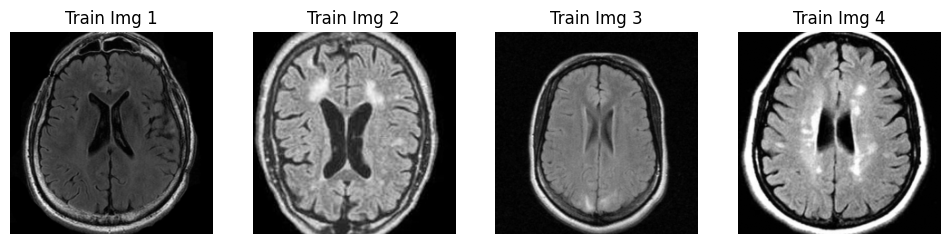

In [9]:
import matplotlib.pyplot as plt

images = next(iter(train_loader))

print(f"Formato del batch (Batch_size, Canali, Altezza, Larghezza): {images.shape}")

# Visualizziamo le prime 4 immagini per vedere l'effetto delle trasformazioni
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    # Squeeze serve per passare da (1, 128, 128) a (128, 128) per il plot
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Train Img {i+1}")
    plt.axis('off')
plt.show()

In [10]:
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.relu(x + self.conv(x))

class VAE_V4(nn.Module):
    def __init__(self, latent_dim=1024):
        super(VAE_V4, self).__init__()

        # ENCODER
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False), # 112x112
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            ResBlock(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False), # 56x56
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            ResBlock(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False), # 28x28
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ResBlock(256),

            # COMPRESSIONE FILTRI: Da 256 a 128 prima del Flatten
            nn.Conv2d(256, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.flatten_dim = 128 * 28 * 28 # 100.352
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # DECODER
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)
        self.unflatten = nn.Unflatten(1, (128, 28, 28))

        self.decoder = nn.Sequential(
            # ESPANSIONE FILTRI: Da 128 a 256
            nn.Conv2d(128, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ResBlock(256),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1, bias=False), # 56x56
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            ResBlock(128),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1, bias=False), # 112x112
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            ResBlock(64),
            nn.ConvTranspose2d(64, 1, 7, stride=2, padding=3, output_padding=1, bias=False), # 224x224
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        h = torch.flatten(h, start_dim=1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)

        x_recon = self.decoder(self.unflatten(self.decoder_input(z)))
        return x_recon, mu, logvar

In [11]:
import torch.nn.functional as F
import time

def loss_function(recon_x, x, mu, logvar, beta=0.01): # Beta aumentato
    # MSE
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    # KL Divergence
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # combinazione pesata
    return recon_loss + (beta * kl_loss), recon_loss, kl_loss


In [12]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, loader):
    model.eval()
    with torch.no_grad():
        # Funzione di utilità per invertire la normalizzazione (mri_std=0.22, mri_mean=0.45)
        def denorm(x):
            return (x * 0.22) + 0.45

        # estrai batch
        data = next(iter(loader))
        data = data.to(device)

        # Ottiene la ricostruzione
        recon, _, _ = model(data)

        # Plot dei primi 2 esempi
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        for i in range(2):
            # Originale (Denormalizzato e clippato tra 0 e 1)
            img_orig = denorm(data[i]).cpu().squeeze().clamp(0, 1)
            axes[i, 0].imshow(img_orig, cmap='gray')
            axes[i, 0].set_title("Originale (V4-Zoom)")
            axes[i, 0].axis('off')

            # Ricostruito (Denormalizzato e clippato tra 0 e 1)
            img_recon = denorm(recon[i]).cpu().squeeze().clamp(0, 1)
            axes[i, 1].imshow(img_recon, cmap='gray')
            axes[i, 1].set_title("Ricostruzione V4")
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()

In [13]:
# 1. Istanza modello V4
model = VAE_V4(latent_dim=1024).to(device)

# 2. Optimizer: LR a 5e-5 per gestire l'architettura profonda
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

# 3. Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

best_val_loss = float('inf')
train_losses = []
val_losses = []

print(f"✅ Modello V4 inizializzato.")
print(f"Parametri totali: {sum(p.numel() for p in model.parameters()):,}")

✅ Modello V4 inizializzato.
Parametri totali: 312,295,424


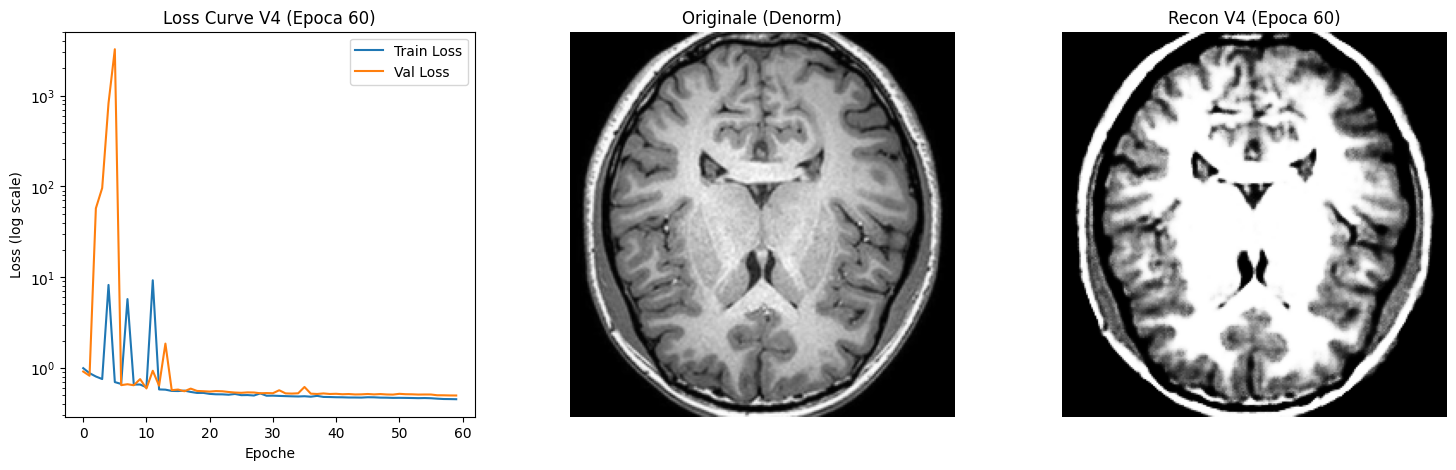

Epoca [60/100] | Train: 0.451934 | Val: 0.496736 | LR: 2.5e-05
 Miglior modello V4 salvato!


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.utils as utils

# --- CONFIGURAZIONE V4 ---
save_path_v4 = "/content/drive/MyDrive/VAE_Brain_Project/best_model_v4.pth"
train_losses = []
val_losses = []
best_val_loss = float('inf')
beta_val = 0.01
num_epochs = 100

print(f"Inizio Training V4 su {device}...")

for epoch in range(num_epochs):
    # TRAINING
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        recon, mu, logvar = model(batch)

        loss, mse, kl = loss_function(recon, batch, mu, logvar, beta=beta_val)

        loss.backward()

        # Gradient Clipping per stabilità con i Residual Blocks
        utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    avg_train = train_loss / len(train_loader)
    train_losses.append(avg_train)

    # FASE DI VALIDAZIONE
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            loss, _, _ = loss_function(recon, batch, mu, logvar, beta=beta_val)
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    # Aggiornamento Scheduler
    scheduler.step(avg_val)

    # Salvataggio miglior modello
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), save_path_v4)
        status_save = " Miglior modello V4 salvato!"
    else:
        status_save = ""

    # --- VISUALIZZAZIONE OGNI 10 EPOCHE (ORA INDENTATA CORRETTAMENTE) ---
    if (epoch + 1) % 10 == 0 or epoch == 0:
        clear_output(wait=True)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # 1. Plot delle Loss
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Val Loss')
        ax1.set_yscale('log')
        ax1.set_title(f"Loss Curve V4 (Epoca {epoch+1})")
        ax1.set_xlabel("Epoche")
        ax1.set_ylabel("Loss (log scale)")
        ax1.legend()

        # 2. Visualizzazione Ricostruzione
        with torch.no_grad():
            def denorm(x):
                return x * 0.22 + 0.45

            sample_batch = next(iter(val_loader)).to(device)
            sample_recon, _, _ = model(sample_batch)

            img_orig = denorm(sample_batch[0]).cpu().squeeze().clamp(0, 1)
            img_recon = denorm(sample_recon[0]).cpu().squeeze().clamp(0, 1)

            ax2.imshow(img_orig, cmap='gray')
            ax2.set_title("Originale (Denorm)")
            ax2.axis('off')

            ax3.imshow(img_recon, cmap='gray')
            ax3.set_title(f"Recon V4 (Epoca {epoch+1})")
            ax3.axis('off')

        plt.show()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoca [{epoch+1}/{num_epochs}] | Train: {avg_train:.6f} | Val: {avg_val:.6f} | LR: {current_lr:.1e}")
        print(status_save)

In [ ]:
# caricamento rapido del modello V4

from google.colab import drive
import torch


if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Definisci dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Inizializza il modello V4
model = VAE_V4(latent_dim=1024).to(device)

# Carica i pesi salvati
model_path_v4 = "/content/drive/MyDrive/VAE_Brain_Project/best_model_v4.pth"

try:
    # Caricamento dei pesi
    checkpoint = torch.load(model_path_v4, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval() # modalità inferenza
    print(f"✅ Modello V4 caricato correttamente!")
    print(f"Capacità del modello: {sum(p.numel() for p in model.parameters()):,} parametri.")

except FileNotFoundError:
    print(f"❌ Errore: Il file '{model_path_v4}' non esiste. Devi prima completare almeno un'epoca di training della V4.")
except RuntimeError as e:
    print(f"❌ Errore di architettura: Incompatibilità tra i pesi salvati e la struttura VAE_V4 definita.\n{e}")

In [ ]:
save_dir = "/content/drive/MyDrive/VAE_Brain_Project"

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def get_anomaly_scores(model, loader):
    model.eval()
    scores = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            recon, _, _ = model(batch)
            # Calcolo MSE per ogni immagine nel batch
            mse = torch.mean((batch - recon)**2, dim=(1, 2, 3))
            scores.extend(mse.cpu().numpy())
    return np.array(scores)

# --- CARICAMENTO MODELLO V4 ---
save_path_v4 = "/content/drive/MyDrive/VAE_Brain_Project/best_model_v4.pth"
try:
    model.load_state_dict(torch.load(save_path_v4, map_location=device))
    model.eval()
    print(f"✅ Modello V4 caricato correttamente.")
except Exception as e:
    print(f"❌ Errore caricamento: {e}")

# 1. Otteniamo i punteggi
print("Calcolo punteggi di anomalia...")
test_healthy_scores = get_anomaly_scores(model, test_loader_sani)
test_anomaly_scores = get_anomaly_scores(model, anno_loader)

y_true = np.array([0] * len(test_healthy_scores) + [1] * len(test_anomaly_scores))
y_scores = np.concatenate([test_healthy_scores, test_anomaly_scores])

# 2. Calcolo metriche e soglia Youden
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_value = roc_auc_score(y_true, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 3. Gestione Inversione e Predizioni
is_inverted = np.mean(test_anomaly_scores) < np.mean(test_healthy_scores)
if is_inverted:
    y_pred = [1 if s < optimal_threshold else 0 for s in y_scores]
    display_auc = 1 - auc_value if auc_value < 0.5 else auc_value
else:
    y_pred = [1 if s > optimal_threshold else 0 for s in y_scores]
    display_auc = auc_value

# --- VISUALIZZAZIONE COMPLETA ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# A. Curva ROC
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {display_auc:.3f}')
ax1.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax1.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='Soglia Ottimale')
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")

# B. Istogramma Distribuzione Errori
ax2.hist(test_healthy_scores, bins=30, alpha=0.5, label='Sani', color='blue', density=True)
ax2.hist(test_anomaly_scores, bins=30, alpha=0.5, label='Anomalie', color='red', density=True)
ax2.axvline(optimal_threshold, color='green', linestyle='--', label=f'Soglia: {optimal_threshold:.4f}')
ax2.set_title('Distribuzione Errori MSE')
ax2.set_xlabel('Score Anomalia')
ax2.legend()

# C. Matrice di Confusione
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sano', 'Anomalia'])
disp.plot(ax=ax3, cmap='Blues', values_format='d')
ax3.set_title('Matrice di Confusione')

plt.tight_layout()
plt.show()

print(f"\n--- PERFORMANCE REPORT V4 ---")
print(classification_report(y_true, y_pred, target_names=['Sano', 'Anomalia']))

In [ ]:
print(f"Media Errore Sani: {test_healthy_scores.mean():.6f}")
print(f"Media Errore Anomalie: {test_anomaly_scores.mean():.6f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(test_healthy_scores, bins=50, alpha=0.5, label='Sani')
plt.hist(test_anomaly_scores, bins=50, alpha=0.5, label='Anomalie')
plt.legend()
plt.title("Distribuzione degli Errori di Ricostruzione")
plt.show()

In [ ]:
def plot_debug_comparison(model, loader_sani, loader_anno):
    model.eval()
    with torch.no_grad():
        # Prendi un esempio sano e uno anomalo
        img_sano = next(iter(loader_sani))[0:1].to(device)
        img_anno = next(iter(loader_anno))[0:1].to(device)

        # Ricostruzioni
        rec_sano, _, _ = model(img_sano)
        rec_anno, _, _ = model(img_anno)

        # Mappe di differenza (errore assoluto)
        diff_sano = torch.abs(img_sano - rec_sano)
        diff_anno = torch.abs(img_anno - rec_anno)

        # Plotting
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Riga Sani
        axes[0,0].imshow(img_sano.cpu().squeeze(), cmap='gray'); axes[0,0].set_title("Originale SANO")
        axes[0,1].imshow(rec_sano.cpu().squeeze(), cmap='gray'); axes[0,1].set_title("Ricostruzione SANO")
        axes[0,2].imshow(diff_sano.cpu().squeeze(), cmap='hot'); axes[0,2].set_title(f"ERRORE (MSE: {torch.mean(diff_sano**2):.6f})")

        # Riga Anomalie
        axes[1,0].imshow(img_anno.cpu().squeeze(), cmap='gray'); axes[1,1].set_title("Originale TUMORE")
        axes[1,1].imshow(rec_anno.cpu().squeeze(), cmap='gray'); axes[1,1].set_title("Ricostruzione TUMORE")
        axes[1,2].imshow(diff_anno.cpu().squeeze(), cmap='hot'); axes[1,2].set_title(f"ERRORE (MSE: {torch.mean(diff_anno**2):.6f})")

        plt.tight_layout()
        plt.show()

plot_debug_comparison(model, test_loader_sani, anno_loader)

In [ ]:
# modello ha assegnato correttamente i labels?
def check_labels_integrity(file_sani_test, file_anomalie_test):
    plt.figure(figsize=(10, 5))

    # Prendi il primo file della lista test sani
    img_sana_path = file_sani_test[0]
    img_sana = Image.open(img_sana_path).convert('L')

    # Prendi il primo file della lista anomalie
    img_anno_path = file_anomalie_test[0]
    img_anno = Image.open(img_anno_path).convert('L')

    plt.subplot(1, 2, 1)
    plt.imshow(img_sana, cmap='gray')
    plt.title(f"LABEL: SANO\nPath: ...{img_sana_path[-30:]}")

    plt.subplot(1, 2, 2)
    plt.imshow(img_anno, cmap='gray')
    plt.title(f"LABEL: ANOMALIA\nPath: ...{img_anno_path[-30:]}")

    plt.show()

# Usiamo le liste originali dei file per il controllo
check_labels_integrity(test_healthy_subset.dataset.file_list, file_anomalie)